# **Content**
1. [Hazırlayanlar](#1)
1. [Linear Regresyon İle Makine Sayısını Kullanarak Kar ve Zarar Tahmini](#2)
    * [Verinin İncelenmesi](#3)
    * [Linear Regresyon Ve Kar Zarar Tahmin Hipotezi](#4)
    * [Cross Validation](#8)
1. [Çok Değişkenli Regresyon İle Yakıt Tüketimi Tahmini](#5)
    * [Verinin İncelenmesi](#6)
    * [Hipotezin Uygulanması Ve Paremetre Optimizasyonu](#7)

<a id=1></a>
## Hazırlayanlar 

* #### Grup Numarası: 3
* #### Anıl Dursun İpek - 031890131
* #### Batuhan Arslandaş - 032190097

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

<a id=2></a>
## Linear Regresyon İle Makine Sayısını Kullanarak Kar ve Zarar Tahmini

<a id=3></a>
### Verinin İncelenmesi

In [2]:
df_machine = pd.read_csv("machine.data")
df_machine.head()

,NUMBER_OF_MACHINES,PROFIT_LOSS_PER_MONTH
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [3]:
df_machine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NUMBER_OF_MACHINES     97 non-null     float64
 1   PROFIT_LOSS_PER_MONTH  97 non-null     float64
dtypes: float64(2)
memory usage: 1.6 KB


In [4]:
df_machine.describe()

,NUMBER_OF_MACHINES,PROFIT_LOSS_PER_MONTH
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


In [5]:
# Z-Normalization
# Veri seti içindeki değerler standart sapması 1 ortalamsı 0 olacak şekilde tekrar scale edildi
temp_df = df_machine.copy()
def z_normalization(df):
    for i in range(len(df.columns)):
        column = df.columns[i]
        df[column] = (df[column] - np.mean(df[column])) / (np.std(df[column]))
    return df
tem_df = z_normalization(temp_df)
temp_df.head()

,NUMBER_OF_MACHINES,PROFIT_LOSS_PER_MONTH
0,-0.532406,2.143985
1,-0.683683,0.600364
2,0.093198,1.427065
3,-0.300425,1.097246
4,-0.597421,0.179534


In [6]:
# Regresyon algoritması için train seti içerisindeki değerler uygun numpy boyutlarına çevrildi
x = temp_df.NUMBER_OF_MACHINES
y = temp_df.PROFIT_LOSS_PER_MONTH
x = np.array([x])
y = np.array([y])
print(f"X shape: {x.shape} \nY shape: {y.shape}")

X shape: (1, 97) 
Y shape: (1, 97)


In [7]:
temp_df.describe()

,NUMBER_OF_MACHINES,PROFIT_LOSS_PER_MONTH
count,9.700000e+01,9.700000e+01
mean,-6.100504e-16,2.998747e-16
std,1.005195e+00,1.005195e+00
min,-8.137648e-01,-1.554208e+00
25%,-6.369283e-01,-7.027337e-01
50%,-4.079084e-01,-2.329232e-01
75%,1.086526e-01,2.202868e-01
max,3.647694e+00,3.339763e+00


<a id=4></a>
### Linear Regresyon Ve Kar Zarar Tahmin Hipotezi

In [8]:
def initialize_weights_and_bias(dimension):
    """
    Regresyon için toplam feature sayısına uygun olucak şekilde başlangıç parametrelerini oluşturan fonksiyon.
    Başlangıç parametreleri 0.01 olucak şekilde başlatıldı
    Yanlılık 2 değer ile test edild. 1 İle modele eğim oturmadığı için 0 değerine dönüştürüldü
    """
    Q = np.full((dimension,1),0.01) # Başlangıç değerleri 0.01 -> [[0.01,0.01,0.01,0.01 ......]] || Paramtere sayısı kadar
    # w.shape -> (dimension,1)
    b = 0 # Bias(Yanlılık) değeri 1 olarak alındı
    return Q,b

In [9]:
def custFunction(y_calculated, y_train):
    """
    Veri seti ile regresyon hipotezi sonucu oluşan değerlerin arasındaki farklar kullanılarak maliyet 
    fonkisyonu oluşturuldu
    """
    return (1/(2 * y_train.shape[1]) * np.sum((y_calculated - y_train)**2))
def gradientDescent(Q, b, y_calculated, y_train, x_train, learning_rate=0.01):
    """
    Gradient Descent azaltma algoritması ile mevcut parametreler maliyet fonkisyonun türevi alınarak
    ve learning rate ile çarpılarak optimizde edildi.
    """
    Q = Q - ((learning_rate / y_train.shape[1]) * np.sum(np.dot(x_train,(y_calculated - y_train).T)))
    return Q

In [10]:
def linear_regression(x_train, y_train, learning_rate=0.01, iteration=1000):
    """
    Linear Regresyon algoritması ile mevcut parametreler sabit değerler ile başlatılarak gradient descent
    algoritması kullanılarak parametre optimizasyonu sağlandı
    İterasyon sayısı temelde 1000 olarak alındı
    1000 üstü iterasyon sayılarının sonuca çok fazla etki etmediği tespit edildi
    Başlangıç ve bitişteki maliyet hesapları karşılaştırma amacılığıyla çıktı olarak ekrana yazdırıldı
    @param Q: Slope
    @param x: independent veriables
    @param b: Population İntercept || Constant || Bias
    @return predictions
    """
    # Parametre İnitialize
    dimension = x_train.shape[0]
    Q,b = initialize_weights_and_bias(dimension)
    y_calculated = np.dot(Q.T, x_train) + b
    
    # Loss Calculation and Parametre Optimization
    print("First Cost =", custFunction(y_calculated, y_train))
    for i in range(iteration):
        Q = gradientDescent(Q, b, y_calculated=y_calculated, y_train=y_train, x_train=x_train, learning_rate=0.01)
        y_calculated = np.dot(Q.T, x_train) + b
    cost = custFunction(y_calculated, y_train)
    print("Last Cost =", cost)
    
    return y_calculated, cost

In [11]:
prediction,cost = linear_regression(x,y, learning_rate=0.01, iteration=1000)

First Cost = 0.4916712676747367
Last Cost = 0.14898422374661538


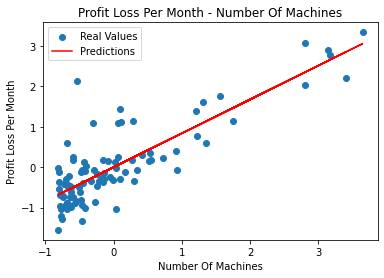

In [12]:
plt.scatter(x[0], y[0], label="Real Values")
plt.plot(x[0], prediction[0],"r", label="Predictions")
plt.xlabel("Number Of Machines")
plt.ylabel("Profit Loss Per Month")
plt.title("Profit Loss Per Month - Number Of Machines")
plt.legend()
plt.show()

<a id=8></a>
### Cross Validation

In [13]:
# Manuel Cross Validation
def cross_validation_linear_regression(data, split=5):
    #ss -> split size
    data = z_normalization(data)
    ss = int(np.round(len(data) / 5))
    folds = [data.iloc[:ss*1], data.iloc[ss*1:ss*2], data.iloc[ss*2:ss*3], data.iloc[ss*3:ss*4], data.iloc[ss*4:]]
    costs = []
    validation = 0
    for fold in folds:
        x = fold.NUMBER_OF_MACHINES
        y = fold.PROFIT_LOSS_PER_MONTH
        x = np.array([x])
        y = np.array([y])
        prediction, cost = linear_regression(x,y, learning_rate=0.01, iteration=1000)
        costs.append(cost)
    print("Ortalama Maliyet Hesabı: ", sum(costs) / 5)

In [14]:
cross_validation_linear_regression(df_machine,5)

First Cost = 0.4380728105138862
Last Cost = 0.3856818635668577
First Cost = 0.9826686310031155
Last Cost = 0.062179031217549134
First Cost = 0.20141752682285424
Last Cost = 0.08606868295108754
First Cost = 0.6433212801317155
Last Cost = 0.08077551038824983
First Cost = 0.22133277349950456
Last Cost = 0.09602361888490006
Ortalama Maliyet Hesabı:  0.14214574140172884


* Cross Validation olmadan hesaplanan maliyet 0.14898422374661538
* Cross Validation İle Hesaplanan ortalama maliyet 0.14214574140172884
* Cross Validation Ortalaması sonucu maliyetin bu hipotez testi için ufak bir miktar azaldığı görülebilir

<a id=5></a>
## Çok Değişkenli Regresyon İle Yakıt Tüketimi Tahmini

<a id=6></a>
### Verinin İncelenmesi

In [15]:
df_auto_mpg = pd.read_csv("auto_mpg.data")
df_auto_mpg.head()

,MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,ORIGIN,CARNAME
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [16]:
len(df_auto_mpg["CARNAME"].unique())

305

In [17]:
# Carname içerisindeki değerler label encoding yöntemi ile kategorik değerlerden numeric değerlere çevrildi
label_encoder = LabelEncoder()
df_auto_mpg["CARNAME"] = label_encoder.fit_transform(df_auto_mpg["CARNAME"])

In [18]:
df_auto_mpg.head()

,MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,ORIGIN,CARNAME
0,18.0,8,307.0,130,3504,12.0,70,1,49
1,15.0,8,350.0,165,3693,11.5,70,1,36
2,18.0,8,318.0,150,3436,11.0,70,1,231
3,16.0,8,304.0,150,3433,12.0,70,1,14
4,17.0,8,302.0,140,3449,10.5,70,1,161


In [19]:
df_auto_mpg.describe()

,MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,ORIGIN,CARNAME
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.296482,2970.424623,15.568090,76.010050,1.572864,148.550251
std,7.815984,1.701004,104.269838,38.224809,846.841774,2.757689,3.697627,0.802055,89.495880
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,0.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000,65.250000
50%,23.000000,4.000000,148.500000,93.000000,2803.500000,15.500000,76.000000,1.000000,150.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000,225.750000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,304.000000


In [20]:
df_auto_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   CYLINDERS     398 non-null    int64  
 2   DISPLACEMENT  398 non-null    float64
 3   HORSEPOWER    398 non-null    int64  
 4   WEIGHT        398 non-null    int64  
 5   ACCELERATION  398 non-null    float64
 6   MODELYEAR     398 non-null    int64  
 7   ORIGIN        398 non-null    int64  
 8   CARNAME       398 non-null    int32  
dtypes: float64(3), int32(1), int64(5)
memory usage: 26.6 KB


In [21]:
temp_df = df_auto_mpg.copy()

In [22]:
# Veri seti içerisindeki bağımlı ve bağımsız değerler ayrıldı
x = temp_df.iloc[:,1:9]
y = temp_df.MPG

In [23]:
x = z_normalization(x)
y = (y - np.mean(y)) / np.std(y)
x.describe()

,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,ORIGIN,CARNAME
count,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02
mean,-7.671139e-16,-1.205066e-16,2.438027e-16,-1.394753e-17,5.903151e-15,-8.837152e-16,-4.535735e-16,1.079538e-16
std,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00
min,-1.444949e+00,-1.204411e+00,-1.527015e+00,-1.604943e+00,-2.747814e+00,-1.627426e+00,-7.151448e-01,-1.661945e+00
25%,-8.563206e-01,-8.563178e-01,-7.411966e-01,-8.828266e-01,-6.328794e-01,-8.150739e-01,-7.151448e-01,-9.319434e-01
50%,-8.563206e-01,-4.314040e-01,-2.958995e-01,-1.973624e-01,-2.472221e-02,-2.721449e-03,-7.151448e-01,1.621944e-02
75%,1.498191e+00,6.584879e-01,5.423069e-01,7.538337e-01,5.834349e-01,8.096310e-01,5.332220e-01,8.636925e-01
max,1.498191e+00,2.511784e+00,3.292671e+00,2.565185e+00,3.351912e+00,1.621983e+00,1.781589e+00,1.739135e+00


In [24]:
x.head()

,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,ORIGIN,CARNAME
0,1.498191,1.090604,0.673277,0.630870,-1.295498,-1.627426,-0.715145,-1.113745
1,1.498191,1.503514,1.590065,0.854333,-1.477038,-1.627426,-0.715145,-1.259185
2,1.498191,1.196232,1.197156,0.550470,-1.658577,-1.627426,-0.715145,0.922428
3,1.498191,1.061796,1.197156,0.546923,-1.295498,-1.627426,-0.715145,-1.505316
4,1.498191,1.042591,0.935216,0.565841,-1.840117,-1.627426,-0.715145,0.139285


In [25]:
y.head()

0   -0.706439
1   -1.090751
2   -0.706439
3   -0.962647
4   -0.834543
Name: MPG, dtype: float64

<a id=7></a>
### Hipotezin Uygulanması Ve Paremetre Optimizasyonu

In [26]:
# Fonksiyon için bağımlı ve bağımsız değerler uygun shape'lere dönüştürüldü
x = x.T
y = np.array([y])

In [27]:
print(f"X shape: {x.shape} \nY shape: {y.shape}")

X shape: (8, 398) 
Y shape: (1, 398)


In [28]:
def multivariable_linear_regression_2(x_train, y_train, learning_rate=0.01, iteration=1000):
    """
    @param Q: Slope
    @param x: independent veriables
    @param b: Population İntercept || Constant || Bias
    @return prediction
    """
    # Parametre İnitialize
    dimension = x_train.shape[0]
    Q,b = initialize_weights_and_bias(dimension)
    y_calculated = np.dot(Q.T, x_train) + b
    print("Q shape: ", Q.T.shape , " x shape: ", x.shape)
    
    # Loss Calculation
    print("First Cost =", custFunction(y_calculated, y_train))
    for i in range(iteration):
        Q = gradientDescent(Q, b, y_calculated=y_calculated, y_train=y_train, x_train=x_train, learning_rate=0.01)
        y_calculated = np.dot(Q.T, x) + b
    print("Last Cost =", custFunction(y_calculated, y_train))
    print(Q)
    return y_calculated

In [29]:
prediction = multivariable_linear_regression_2(x,y)

Q shape:  (1, 8)  x shape:  (8, 398)
First Cost = 0.5138554877361085
Last Cost = 0.379288873554236
[[-0.17910727]
 [-0.17910727]
 [-0.17910727]
 [-0.17910727]
 [-0.17910727]
 [-0.17910727]
 [-0.17910727]
 [-0.17910727]]


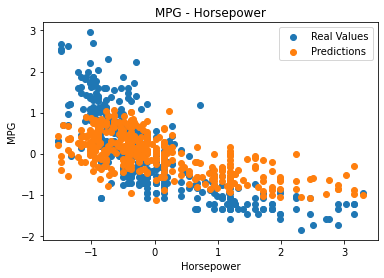

In [30]:
plt.scatter(x.to_numpy()[2], y[0], label="Real Values")
plt.scatter(x.to_numpy()[2], prediction[0], label="Predictions")
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("MPG - Horsepower")
plt.legend()
plt.show()

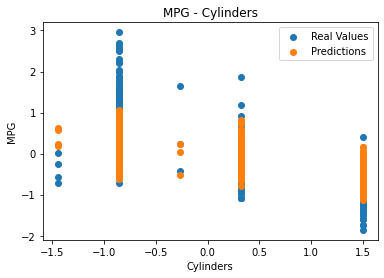

In [31]:
plt.scatter(x.to_numpy()[0], y[0], label="Real Values")
plt.scatter(x.to_numpy()[0], prediction[0], label="Predictions")
plt.xlabel("Cylinders")
plt.ylabel("MPG")
plt.title("MPG - Cylinders")
plt.legend()
plt.show()

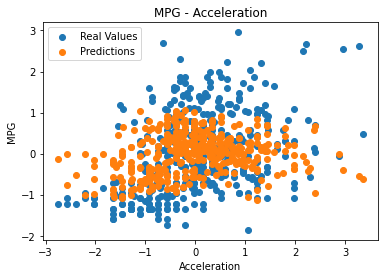

In [32]:
plt.scatter(x.to_numpy()[4], y[0], label="Real Values")
plt.scatter(x.to_numpy()[4], prediction[0], label="Predictions")
plt.xlabel("Acceleration")
plt.ylabel("MPG")
plt.title("MPG - Acceleration")
plt.legend()
plt.show()

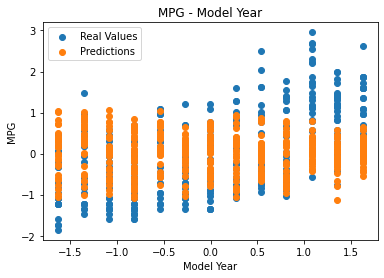

In [33]:
plt.scatter(x.to_numpy()[5], y[0], label="Real Values")
plt.scatter(x.to_numpy()[5], prediction[0], label="Predictions")
plt.xlabel("Model Year")
plt.ylabel("MPG")
plt.title("MPG - Model Year")
plt.legend()
plt.show()